# importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
#models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report

# Reading Data

In [2]:
rs = 0
df = pd.read_csv(f'MCSDatasetNEXTCONLab.csv')
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
trDf = df[:10139][:]
teDf = df[10139:][:]
trDf = trDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
trDf = trDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
teDf = teDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
teDf = teDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
trY = trDf['Ligitimacy'].values
teY = teDf['Ligitimacy'].values
trX = trDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values
teX = teDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values

In [3]:
trDf

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,4421.4189,-3033.6925,1,4,13,40,40,9,91,0,131380,1
1,1,4421.5414,-3043.6606,1,4,23,40,30,9,91,0,131380,1
2,1,4421.0414,-3039.6326,1,4,33,40,20,9,91,0,121996,1
3,1,4418.6802,-3035.7741,1,4,43,40,10,9,91,0,121996,1
4,2,4477.2690,-1477.2228,2,15,49,30,30,5,47,0,140784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10134,2820,5398.0715,-1363.8483,3,4,50,40,20,1,87,0,290929,1
10135,2820,5404.4717,-1361.2367,3,5,0,40,10,1,87,0,300313,1
10136,2821,5435.2708,-2177.0007,2,19,44,40,40,5,35,0,300303,1
10137,2821,5435.5436,-2178.3546,2,19,54,40,30,5,35,0,300303,1


### biased data
The next line shows that the data is biased, number of data labeled '1' is too much more than the data labeled '-1'

 1    8839
-1    1300
Name: Ligitimacy, dtype: int64


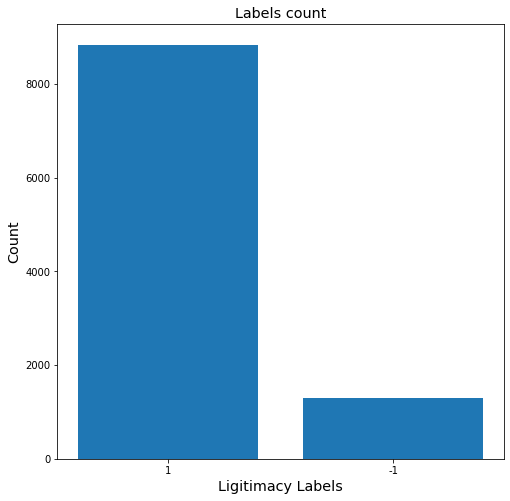

In [4]:
print(trDf['Ligitimacy'].value_counts())
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(['1', '-1'], trDf['Ligitimacy'].value_counts())
plt.title('Labels count', fontsize = 'x-large')
plt.ylabel('Count', fontsize = 'x-large')
plt.xlabel('Ligitimacy Labels', fontsize = 'x-large')
plt.show()


In [5]:
# converting to data frame
xtrain = pd.DataFrame(trX,columns = ["Latitude", "Longitude", "Hour", "Minute", "Duration", "RemainingTime", "Resources", "Coverage", "OnPeakHours", "GridNumber"]) 
xtest = pd.DataFrame(teX,columns = ["Latitude", "Longitude", "Hour", "Minute", "Duration", "RemainingTime", "Resources", "Coverage", "OnPeakHours", "GridNumber"])
ytrain =pd.DataFrame(trY,columns = ["Ligitimacy"])
ytest =pd.DataFrame(teY,columns = ["Ligitimacy"])

In [6]:
xtrain

,Latitude,Longitude,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,4421.4189,-3033.6925,4.0,13.0,40.0,40.0,9.0,91.0,0.0,131380.0
1,4421.5414,-3043.6606,4.0,23.0,40.0,30.0,9.0,91.0,0.0,131380.0
2,4421.0414,-3039.6326,4.0,33.0,40.0,20.0,9.0,91.0,0.0,121996.0
3,4418.6802,-3035.7741,4.0,43.0,40.0,10.0,9.0,91.0,0.0,121996.0
4,4477.2690,-1477.2228,15.0,49.0,30.0,30.0,5.0,47.0,0.0,140784.0
...,...,...,...,...,...,...,...,...,...,...
10134,5398.0715,-1363.8483,4.0,50.0,40.0,20.0,1.0,87.0,0.0,290929.0
10135,5404.4717,-1361.2367,5.0,0.0,40.0,10.0,1.0,87.0,0.0,300313.0
10136,5435.2708,-2177.0007,19.0,44.0,40.0,40.0,5.0,35.0,0.0,300303.0
10137,5435.5436,-2178.3546,19.0,54.0,40.0,30.0,5.0,35.0,0.0,300303.0


### check for null values

In [7]:
print(xtrain.isnull().values.any())
print(xtest.isnull().values.any())
print(ytrain.isnull().values.any())
print(ytest.isnull().values.any())

False
False
False
False


### data correlations

<AxesSubplot:>

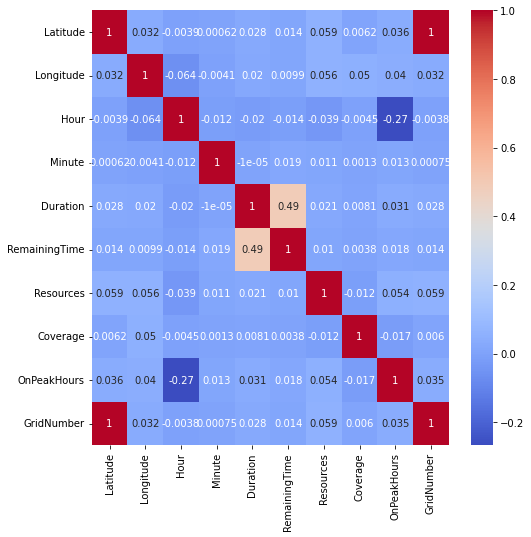

In [8]:
# Plot the coorelation between features
plt.figure(figsize=(8,8))
sns.heatmap(xtrain.corr(), annot = True, cmap = 'coolwarm')

## comment
There are a positive correlation between both GridNumber and Latitude

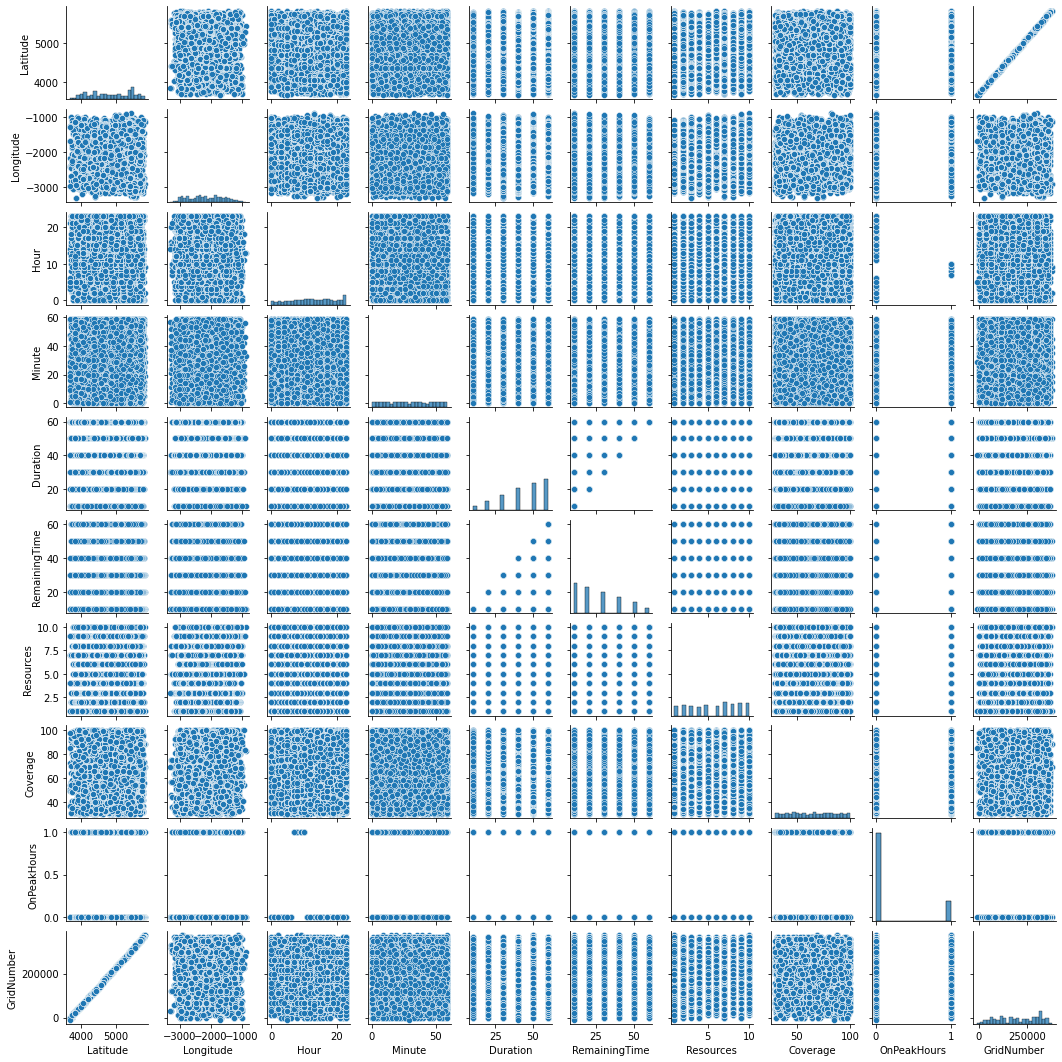

In [9]:
sns.pairplot(xtrain, height = 1.5)

# Functions

In [10]:
def model_Boosting(nEst, lr, x_train, y_train, x_test, y_test):
    classifier = AdaBoostClassifier(n_estimators = nEst, learning_rate = lr, random_state=0)
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'Adaboost: {accuracy}')
    plot_confusion_matrix(classifier, x_test, y_test)

    return classifier, ypred, accuracy

In [11]:
def model_knn(x_train, y_train, x_test, y_test):
    classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'K-NN: {accuracy}')
    plot_confusion_matrix(classifier, x_test, y_test)
    
    return classifier, ypred, accuracy

In [12]:
def model_decisiontree(x_train, y_train, x_test, y_test):
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'Decision Tree: {accuracy}')
    plot_confusion_matrix(classifier, x_test, y_test)
    
    return classifier, ypred, accuracy

In [13]:
# def model_svm(x_train, y_train, x_test, y_test):
#     classifier = SVC(kernel = 'rbf', random_state = 0)
#     classifier.fit(x_train, y_train)
#     ypred = classifier.predict(x_test)
#     accuracy = accuracy_score(y_test, ypred)
#     print(accuracy*100)
#     plot_confusion_matrix(classifier, x_test, y_test)
    
#     return classifier, ypred, accuracy

In [14]:
# def model_logisticregression(x_train, y_train, x_test, y_test):
#     classifier = LogisticRegression(random_state = 0)
#     classifier.fit(x_train, y_train)
#     ypred = classifier.predict(x_test)
#     accuracy = accuracy_score(y_test, ypred)
#     print(accuracy*100)
#     plot_confusion_matrix(classifier, x_test, y_test)
    
#     return classifier, ypred, accuracy

In [15]:
def plt_bar(labels_name, yvalues, baseline, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(labels_name, baseline, color='red', marker='o',
                     linestyle='dashed', label = 'Baseline')
    plt.bar(labels_name, yvalues)
    plt.title(title, fontsize = 'x-large')
    plt.ylabel(ylabel, fontsize = 'x-large')
    plt.xlabel(xlabel, fontsize = 'x-large')
    plt.yticks(np.arange(90, 101, 0.5))
    plt.ylim(ymin = 90)
    ax.set_xlim(xmin = -0.7, xmax = 3)
    plt.hlines(yvalues, xmin = [-0.7, -0.7, -0.7], xmax = [-0.4, 0.6, 1.6], colors = 'black', linestyles='dashed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [16]:
def plot_against_Baseline(xvalues, yaxis_values, title):
    colors = []
    plt.figure(figsize=(7,5), dpi=100)        
    axis1 = plt.plot(xvalues, yaxis_values[0], color='red', marker='o',
                     linestyle='dashed', label = 'Baseline')
    axis2 = plt.plot(xvalues, yaxis_values[1], color='green', marker='o', 
                     linestyle='dashed', label = 'over-sampling: SMOTE')
    axis3 = plt.plot(xvalues, yaxis_values[2], color='blue', marker='o', 
                     linestyle='dashed', label = 'over-sampling: ADASYN')
    axis4 = plt.plot(xvalues, yaxis_values[3], color='cyan', marker='o',
                     linestyle='dashed', label = 'Under-sampling: Random Under-sampling')
    
    plt.title(title, fontsize = 'x-large')
    plt.xlabel('Models', fontsize = 'x-large')
    plt.ylabel('Accuracy %', fontsize = 'x-large')
    plt.ylim(ymin = 90)
    plt.yticks(np.arange(90, 101, 0.5))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show

In [17]:
def plot_features_vs_accuracy(xvalues, accuracies_values, baseline_accuracies, title, xlabel, ylabel):
    plt.figure(figsize=(8,8), dpi=100)
    plt.plot(xvalues, accuracies_values, color='green', marker='o', 
            linestyle='dashed', label = 'MLP accuracies')
    plt.plot(xvalues, baseline_accuracies, color='red', marker='o', 
            linestyle='dashed', label = 'Baseline Accuracies')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xvalues)
    plt.yticks(np.arange(84,101, 2))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show

In [18]:
def plot_data(x, y, model, title):
    cls =len(set(y))
    X, Y = np.array(x), np.array(y) #convert to numpy
    plt.figure(figsize=(7,5), dpi=250)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.YlGnBu)

    plt.xlabel('X1')
    plt.ylabel('X2')
    
    plot_colors = ['orange','green','purple', 'red', 'blue', 'cyan']
    # Plot the training points
    for i, color in zip(range(cls), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,
                    cmap=plt.cm.YlGnBu, edgecolor='black', s=10)

    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis("tight")
    plt.show()

# Implementation

## Baseline estimators

1) I tried to fit the models directly to the data, then dropped one of the correlated columns and refit the models.
by comparing the accuracies, I found that I should not drop the feature, as the accuracy of the models fall down after dropping the "GridNumber" feature

2) Choose the three models that give the best accuracies and use them as baseline estimaotrs
("AdaBoost", "K-NN", "Decision-Tree")

In [19]:
all_accuracies = []
base_accuracies = []

Adaboost: 98.204833141542


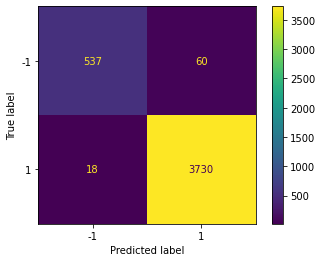

In [20]:
ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, xtrain, ytrain, xtest, ytest)
base_accuracies.append(ada_accuracy)

K-NN: 98.08975834292289


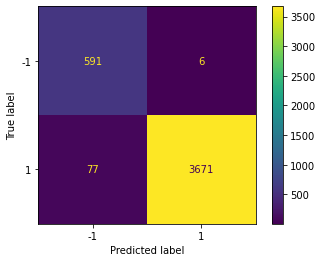

In [21]:
knn_model, knn_pred, knn_accuracy = model_knn(xtrain, ytrain, xtest, ytest)
base_accuracies.append(knn_accuracy)

Decision Tree: 95.35097813578827


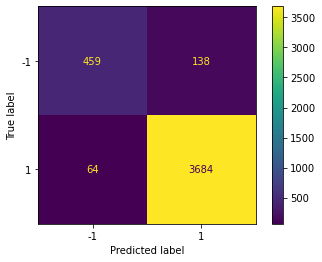

In [22]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(xtrain, ytrain, xtest, ytest)
base_accuracies.append(dt_accuracy)

In [23]:
all_accuracies.append(base_accuracies)

In [24]:
# lr_model, lr_pred, lr_accuracy = model_logisticregression(xtrain, ytrain, xtest, ytest)

In [25]:
# svm_model, svm_pred, svm_accuracy = model_svm(xtrain, ytrain, xtest, ytest)

In [26]:
# # try to drop one of the correlated columns
# new_train_x = xtrain.drop(labels = 'GridNumber', axis = 1)
# new_test_x = xtest.drop(labels = 'GridNumber', axis = 1)

In [27]:
# ada_model_new, ada_pred_new, ada_accuracy_new = model_Boosting(100, 1, new_train_x, ytrain, new_test_x, ytest)

In [28]:
# knn_model, knn_pred, knn_accuracy = model_knn(new_train_x, ytrain, new_test_x, ytest)

In [29]:
# dt_model, dt_pred, dt_accuracy = model_decisiontree(new_train_x, ytrain, new_test_x, ytest)

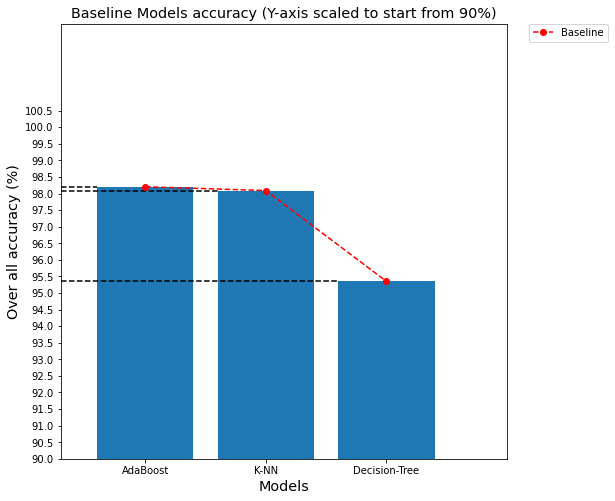

In [30]:
plt_bar(["AdaBoost", "K-NN", "Decision-Tree"], [ada_accuracy, knn_accuracy, dt_accuracy], [ada_accuracy, knn_accuracy, dt_accuracy], "Baseline Models accuracy (Y-axis scaled to start from 90%)", 'Models', 'Over all accuracy (%)')

## Over Sampling
1) Using SMOTE from Imbalanced Learn

2) using ADASYN from Imbalanced Learn

### 1) SMOTE

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
sm = SMOTE(random_state = rs, sampling_strategy = 'minority')
x_res_sm, y_res_sm = sm.fit_resample(xtrain, ytrain)
smote_accuracy = []

Adaboost: 98.13578826237054


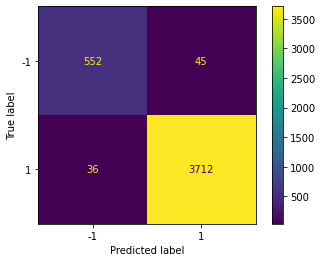

In [33]:
ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_sm, y_res_sm, xtest, ytest)
smote_accuracy.append(ada_accuracy)

K-NN: 97.76754890678941


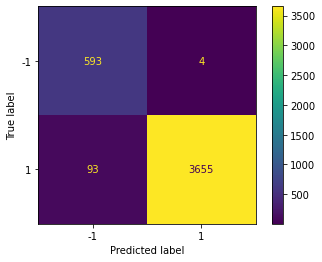

In [34]:
knn_model, knn_pred, knn_accuracy = model_knn(x_res_sm, y_res_sm, xtest, ytest)
smote_accuracy.append(knn_accuracy)

Decision Tree: 94.9367088607595


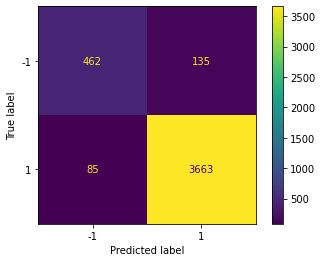

In [35]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(x_res_sm, y_res_sm, xtest, ytest)
smote_accuracy.append(dt_accuracy)

In [36]:
all_accuracies.append(smote_accuracy)

### 2) ADASYN

In [37]:
from imblearn.over_sampling import ADASYN

In [38]:
ads = ADASYN(random_state = rs, sampling_strategy = 'minority')
x_res_ads, y_res_ads = ads.fit_resample(xtrain, ytrain)
adasyn_accuracy = []

Adaboost: 98.11277330264672


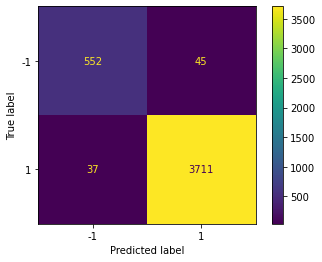

In [39]:
ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_ads, y_res_ads, xtest, ytest)
adasyn_accuracy.append(ada_accuracy)

K-NN: 97.79056386651324


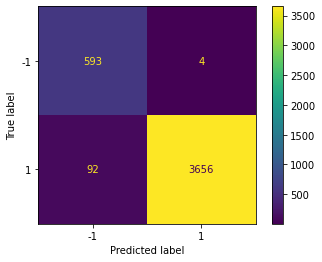

In [40]:
knn_model, knn_pred, knn_accuracy = model_knn(x_res_ads, y_res_ads, xtest, ytest)
adasyn_accuracy.append(knn_accuracy)

Decision Tree: 92.22094361334867


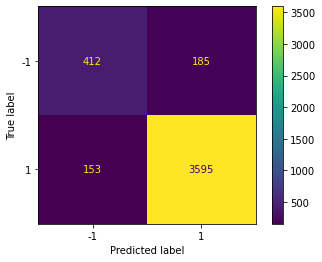

In [41]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(x_res_ads, y_res_ads, xtest, ytest)
adasyn_accuracy.append(dt_accuracy)

In [42]:
all_accuracies.append(adasyn_accuracy)

## under-sampling
using Random Undersampling from Imbalance Learn

In [43]:
from imblearn.under_sampling import RandomUnderSampler

In [44]:
rus = RandomUnderSampler(random_state = rs, sampling_strategy = 'majority')
x_res_rus, y_res_rus = rus.fit_resample(xtrain, ytrain)
random_accuracy = []

Adaboost: 97.67548906789413


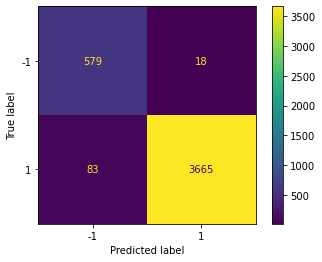

In [45]:
ada_model, ada_pred, ada_accuracy = model_Boosting(400, 1, x_res_rus, y_res_rus, xtest, ytest)
random_accuracy.append(ada_accuracy)

K-NN: 95.30494821634062


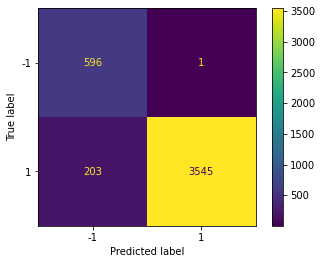

In [46]:
knn_model, knn_pred, knn_accuracy = model_knn(x_res_rus, y_res_rus, xtest, ytest)
random_accuracy.append(knn_accuracy)

Decision Tree: 90.84004602991945


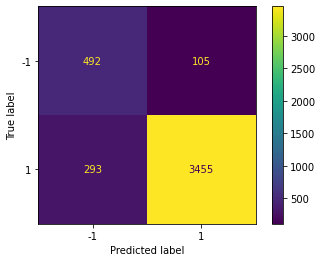

In [47]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(x_res_rus, y_res_rus, xtest, ytest)
random_accuracy.append(dt_accuracy)

In [48]:
all_accuracies.append(random_accuracy)

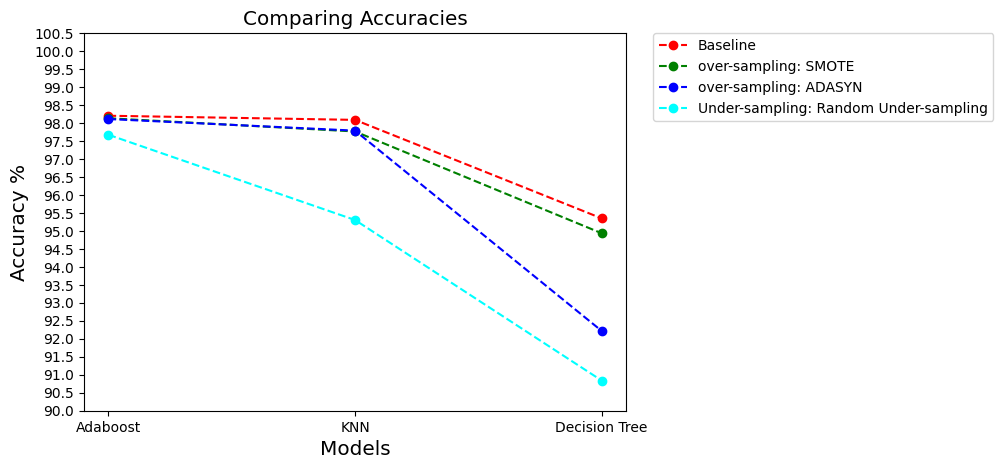

In [49]:
plot_against_Baseline(['Adaboost', 'KNN', 'Decision Tree'], all_accuracies, 'Comparing Accuracies')

Choosing the over-samplping "SMOTE" technique to continue with during later work

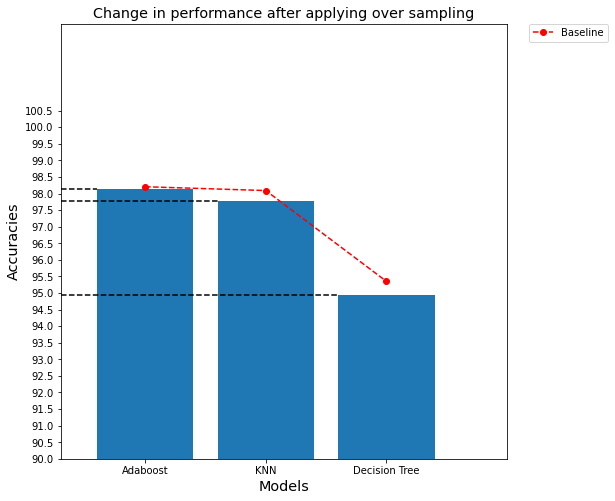

In [50]:
plt_bar(['Adaboost', 'KNN', 'Decision Tree'], smote_accuracy, base_accuracies,'Change in performance after applying over sampling',
        'Models', 'Accuracies')

## applying feature selection and dimensionality reduction

### RFE

In [51]:
from sklearn.feature_selection import RFE

### Applying RFE with adaboost model

Adaboost: 98.34292289988493
Adaboost: 98.38895281933256
Adaboost: 98.45799769850403
Adaboost: 97.99769850402762
Adaboost: 98.18181818181819
Adaboost: 98.3199079401611
Adaboost: 98.204833141542
Adaboost: 98.204833141542


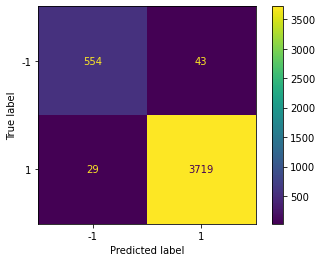

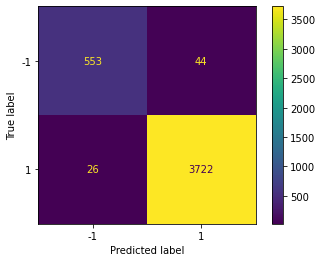

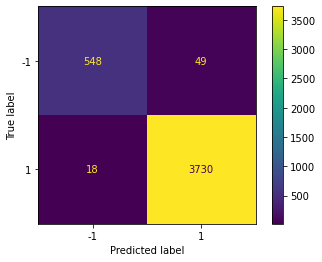

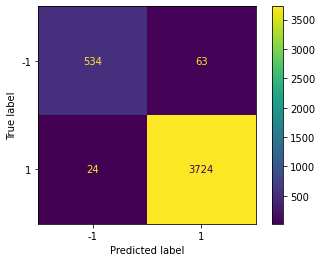

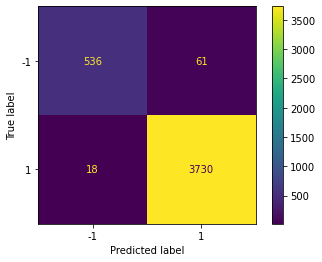

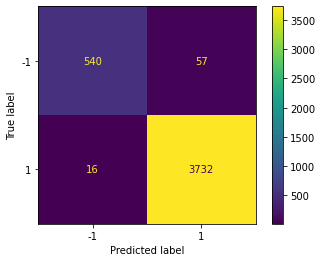

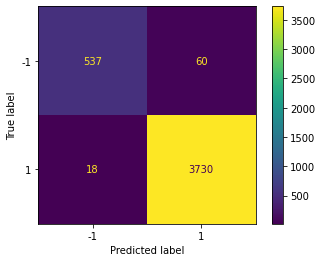

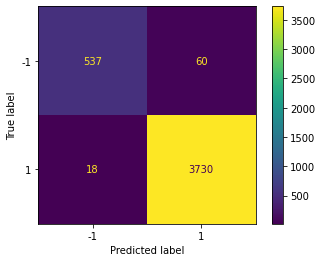

In [52]:
rfe_accuracy = []
ada_selector_accuracy = []
for i in range(3, 11):
    selector = RFE(ada_model, n_features_to_select = i, step=1)
    selector.fit(xtrain, ytrain)
    selector_train = selector.transform(xtrain)
    selector_test = selector.transform(xtest)
    ada_model_selector, ada_pred, ada_accuracy = model_Boosting(400, 1, selector_train, ytrain, selector_test, ytest)
    ada_selector_accuracy.append(ada_accuracy)
    
rfe_accuracy.append(ada_selector_accuracy)

### applying RFE with KNN

Knn is not support the feature selection in scikit learn, So, I cannot use RFE with KNN

In [53]:
rfe_accuracy.append([0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
# knn_model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
# knn_model.fit(xtrain, ytrain)

KNeighborsClassifier()

In [56]:
# knn_selector_accuracy = []
# for i in range(3, 10):
#     selector = RFE(knn_model, n_features_to_select = i, step=1)
#     selector.fit(xtrain, ytrain)
#     selector_train = selector.transform(xtrain)
#     selector_test = selector.transform(xtest)
#     knn_model_selector, knn_pred, knn_accuracy = model_knn(selector_train, ytrain, selector_test, ytest)
#     knn_selector_accuracy.append(knn_accuracy)

### Applying RFE with Decision tree

Decision Tree: 97.12313003452245
Decision Tree: 96.89298043728424
Decision Tree: 96.34062140391254
Decision Tree: 96.15650172612197
Decision Tree: 95.90333716915995
Decision Tree: 95.53509781357883
Decision Tree: 95.42002301495972
Decision Tree: 95.35097813578827


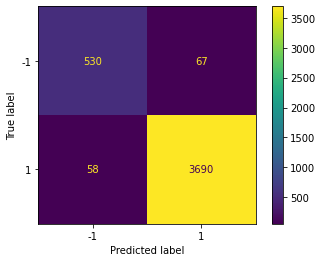

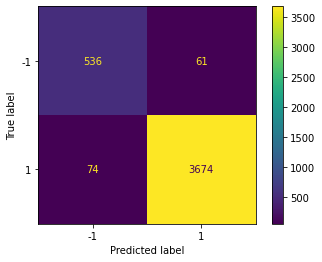

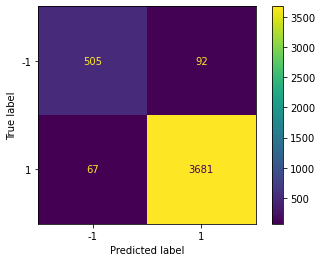

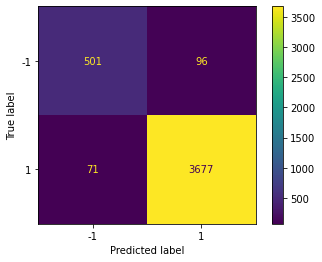

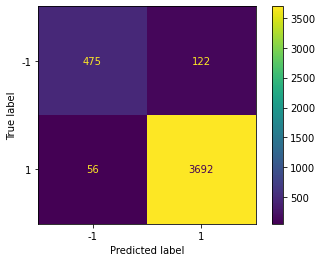

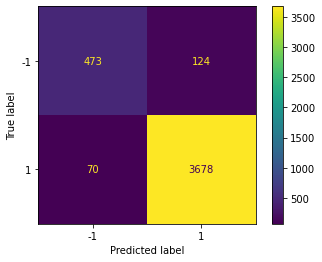

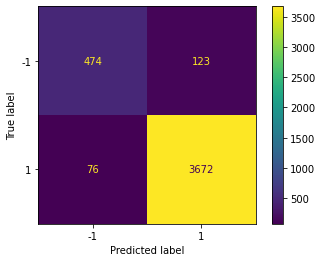

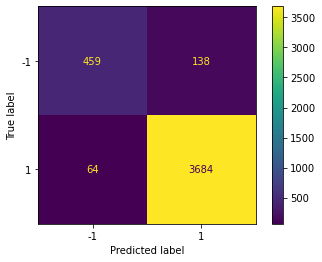

In [57]:
dt_selector_accuracy = []
for i in range(3, 11):
    selector = RFE(dt_model, n_features_to_select = i, step=1)
    selector.fit(xtrain, ytrain)
    selector_train = selector.transform(xtrain)
    selector_test = selector.transform(xtest)
    dt_model_selector, dt_pred, dt_accuracy = model_decisiontree(selector_train, ytrain, selector_test, ytest)
    dt_selector_accuracy.append(dt_accuracy)
rfe_accuracy.append(dt_selector_accuracy)

### Using RandomForest to determine the feature importance

In [58]:
from sklearn.ensemble import RandomForestClassifier
ran_accuracy = []

In [59]:
def model_Randomforest(nEst, x_train, y_train, x_test, y_test):
    model = RandomForestClassifier(n_estimators = nEst, random_state = 0)
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    importance = model.feature_importances_ 
    y_pred = model.predict(x_test)
    
    return importance

In [60]:
importance = model_Randomforest(5, xtrain, ytrain, xtest, ytest)

In [61]:
importance_sorted_indices = np.argsort(importance)[::-1]
importance_sorted_indices

array([9, 0, 1, 2, 6, 8, 7, 4, 3, 5], dtype=int64)

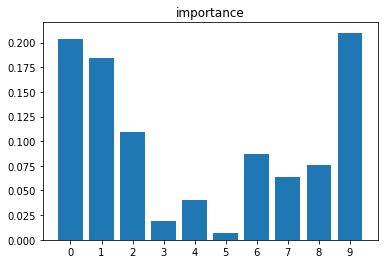

In [62]:
def plot_importance(importance, title):
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    #list(range(len(importance)))
    plt.xticks([x for x in range(len(importance))])
    plt.title(title)
    plt.show()
    
plot_importance(importance, "importance")

In [63]:
feature_list = []
for i in range(3,11):
    feature_list.append(importance_sorted_indices[:i])

Adaboost: 98.34292289988493
Adaboost: 98.41196777905638
Adaboost: 98.06674338319908
Adaboost: 98.11277330264672
Adaboost: 98.11277330264672
Adaboost: 98.3199079401611
Adaboost: 98.204833141542
Adaboost: 98.204833141542


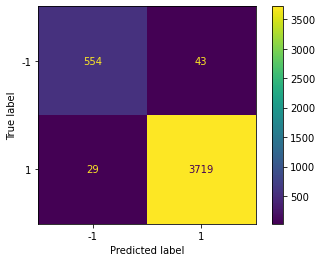

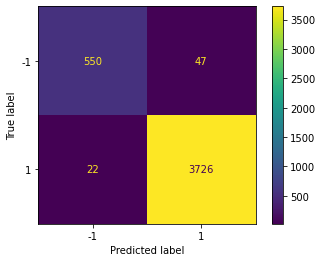

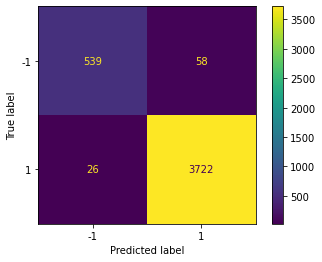

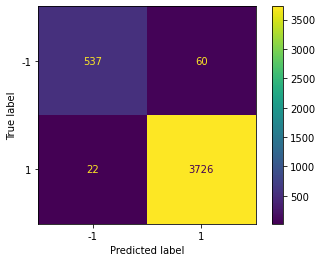

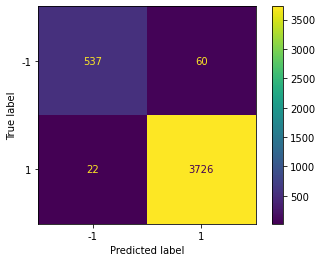

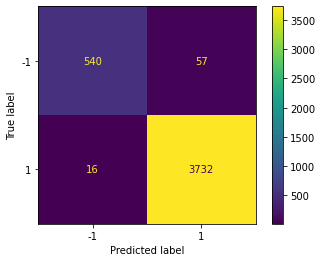

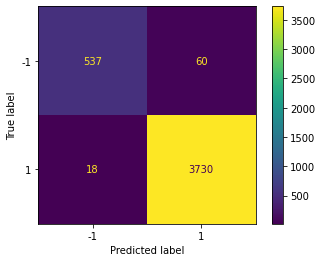

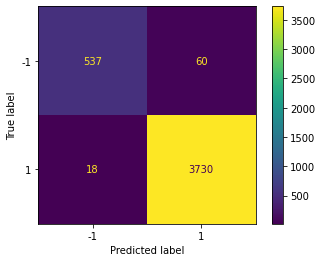

In [64]:
ada_selector_accuracy = []
for i in feature_list:
    ada_model_selector, ada_pred, ada_accuracy = model_Boosting(400, 1, xtrain.iloc[:, i], ytrain, xtest.iloc[:, i], ytest)
    ada_selector_accuracy.append(ada_accuracy)
ran_accuracy.append(ada_selector_accuracy)

K-NN: 98.18181818181819
K-NN: 98.38895281933256
K-NN: 98.45799769850403
K-NN: 98.4349827387802
K-NN: 98.204833141542
K-NN: 97.99769850402762
K-NN: 98.204833141542
K-NN: 98.08975834292289


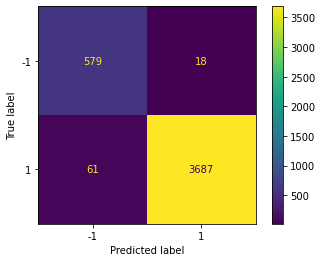

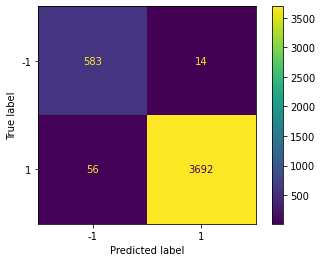

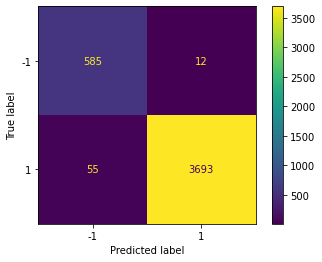

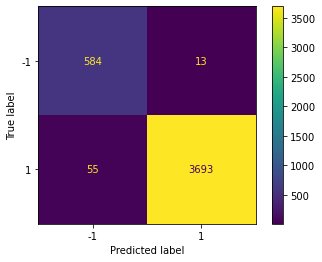

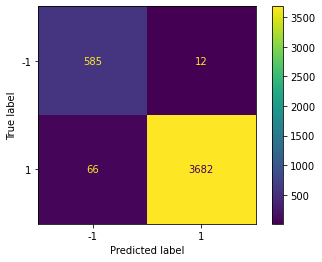

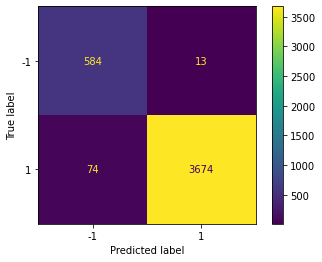

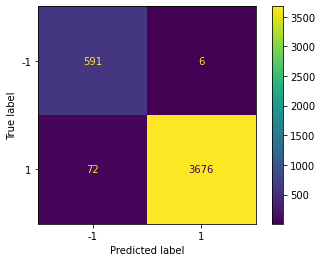

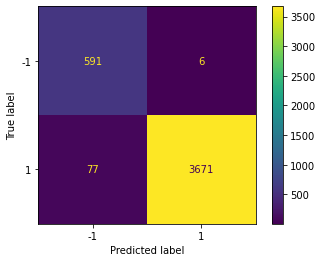

In [65]:
knn_selector_accuracy = []
for i in feature_list:
    knn_model_selector, knn_pred, knn_accuracy = model_knn(xtrain.iloc[:, i], ytrain, xtest.iloc[:, i], ytest)
    knn_selector_accuracy.append(knn_accuracy)
ran_accuracy.append(knn_selector_accuracy)

Decision Tree: 98.7571921749137
Decision Tree: 96.82393555811277
Decision Tree: 96.15650172612197
Decision Tree: 95.74223245109322
Decision Tree: 95.83429228998848
Decision Tree: 95.60414269275029
Decision Tree: 95.53509781357883
Decision Tree: 95.46605293440736


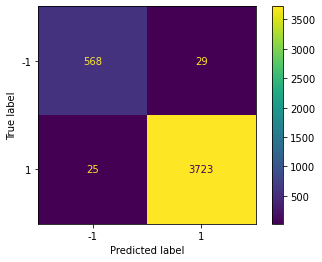

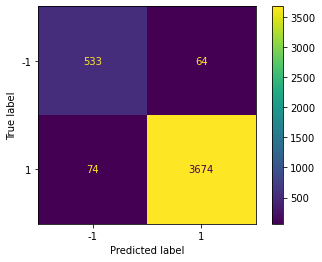

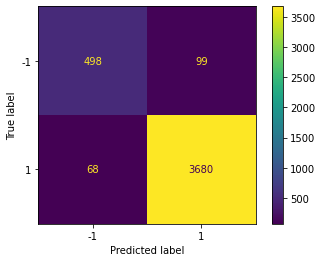

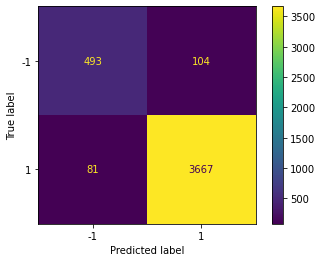

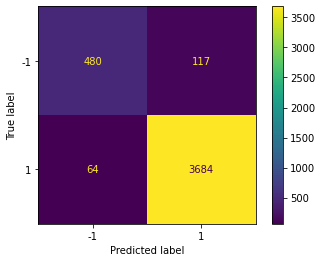

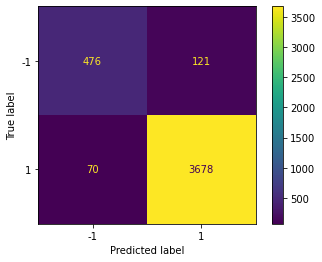

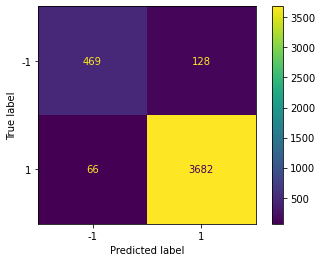

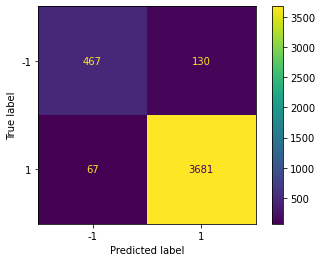

In [66]:
dt_selector_accuracy = []
for i in feature_list:
    dt_model_selector, dt_pred, dt_accuracy = model_decisiontree(xtrain.iloc[:, i], ytrain, xtest.iloc[:, i], ytest)
    dt_selector_accuracy.append(dt_accuracy)
ran_accuracy.append(dt_selector_accuracy)

### PCA dimensionality reduction

In [67]:
from sklearn.decomposition import PCA

In [68]:
pca_accuracy = []

### Applying PCA with AdaBoost

Adaboost: 98.50402761795168
Adaboost: 98.52704257767549
Adaboost: 98.61910241657077
Adaboost: 98.55005753739931
Adaboost: 98.55005753739931
Adaboost: 98.78020713463751
Adaboost: 98.36593785960875
Adaboost: 98.48101265822785


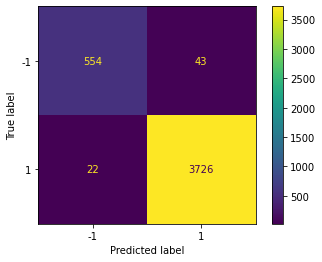

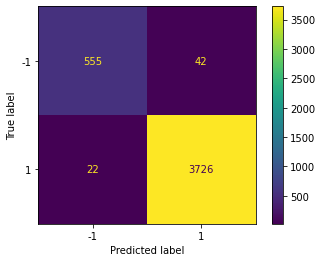

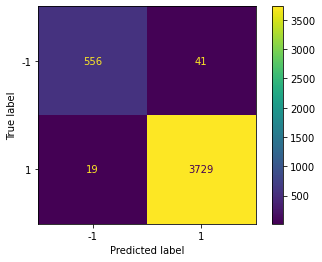

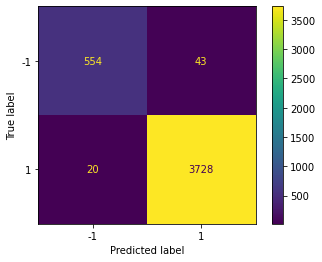

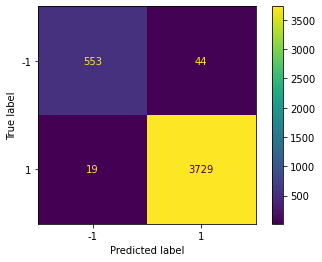

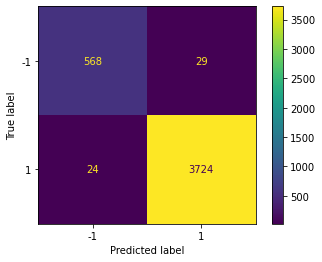

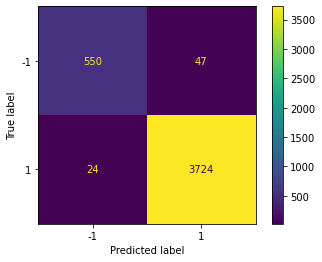

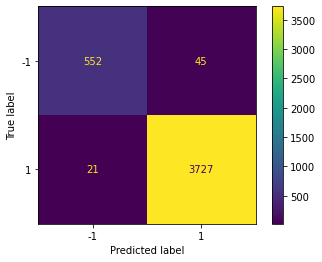

In [69]:
ada_pca_accuracy = []
for i in range(3, 11):
    pca = PCA(n_components = i)
    pca_train = pca.fit_transform(xtrain)
    pca_test = pca.transform(xtest)
    ada_model_pca, ada_pred, ada_accuracy = model_Boosting(400, 1, pca_train, ytrain, pca_test, ytest)
    ada_pca_accuracy.append(ada_accuracy)
pca_accuracy.append(ada_pca_accuracy)

### Applying PCA with KNN

K-NN: 97.26121979286536
K-NN: 97.19217491369389
K-NN: 97.51438434982738
K-NN: 98.06674338319908
K-NN: 98.11277330264672
K-NN: 98.06674338319908
K-NN: 98.08975834292289
K-NN: 98.08975834292289


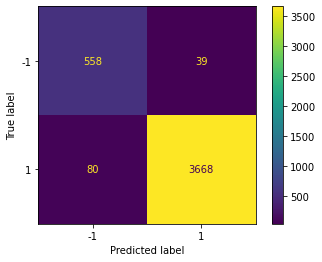

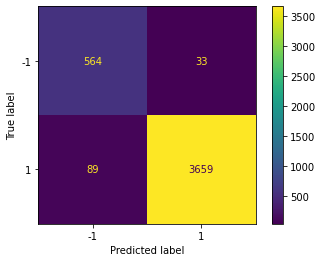

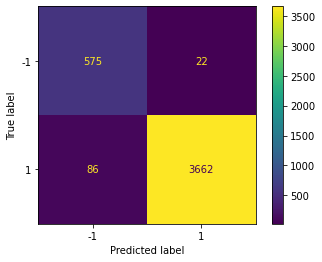

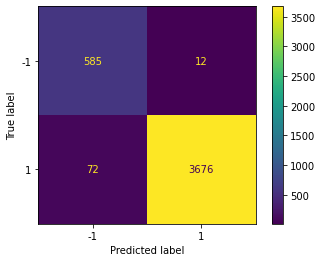

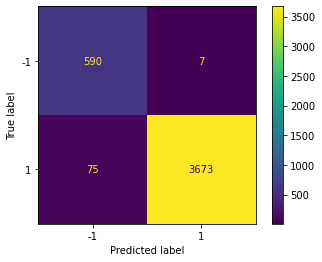

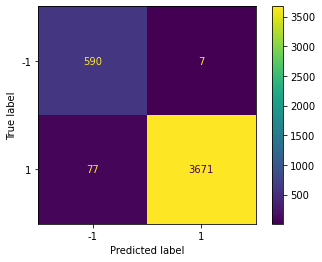

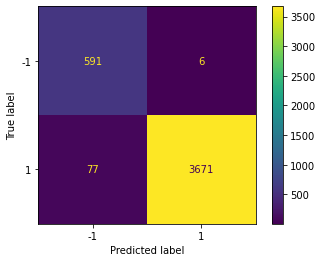

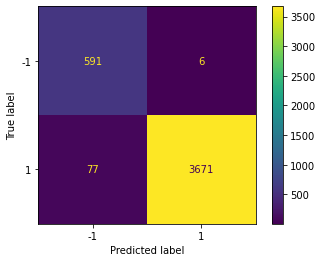

In [70]:
knn_pca_accuracy = []
for i in range(3, 11):
    pca = PCA(n_components = i)
    pca_train = pca.fit_transform(xtrain)
    pca_test = pca.transform(xtest)
    knn_model_pca, knn_pred, knn_accuracy = model_knn(pca_train, ytrain, pca_test, ytest)
    knn_pca_accuracy.append(knn_accuracy)
pca_accuracy.append(knn_pca_accuracy)

Decision Tree: 98.50402761795168
Decision Tree: 98.59608745684694
Decision Tree: 98.84925201380898
Decision Tree: 98.4349827387802
Decision Tree: 98.4349827387802
Decision Tree: 96.89298043728424
Decision Tree: 94.54545454545455
Decision Tree: 93.99309551208286


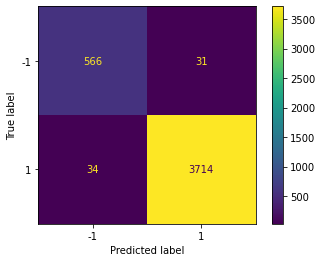

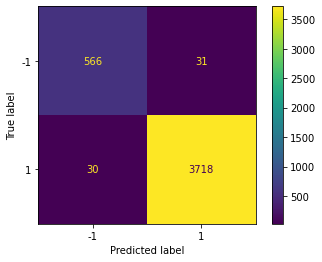

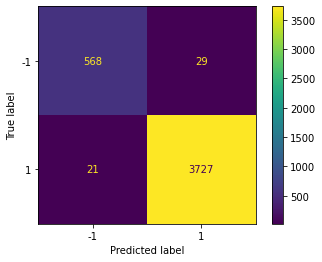

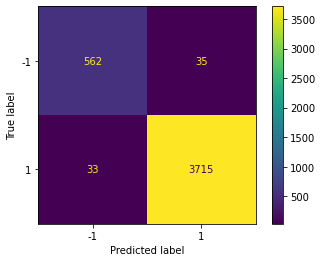

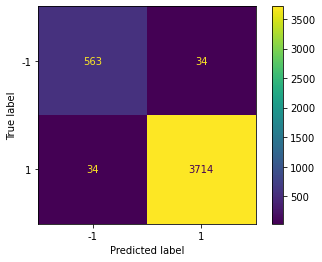

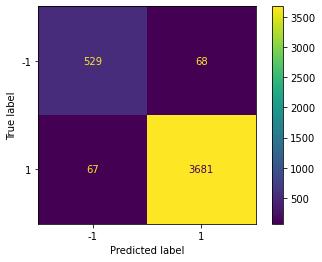

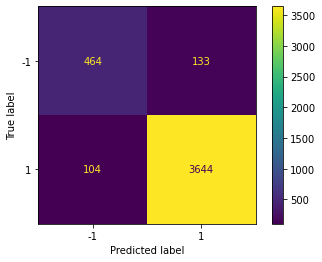

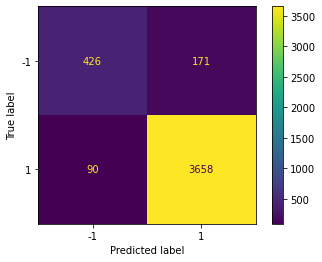

In [71]:
dt_pca_accuracy = []
for i in range(3, 11):
    pca = PCA(n_components = i)
    pca_train = pca.fit_transform(xtrain)
    pca_test = pca.transform(xtest)
    dt_model_pca, dt_pred, dt_accuracy = model_decisiontree(pca_train, ytrain, pca_test, ytest)
    dt_pca_accuracy.append(dt_accuracy)
pca_accuracy.append(dt_pca_accuracy)

In [72]:
feature_selection_accuracy = [rfe_accuracy, ran_accuracy, pca_accuracy]

In [73]:
def plot_against_Baseline2(xvalues, yaxis_values, title):
    colors = []
    plt.figure(figsize=(10,10), dpi=100)
    
    #plotting the accuracies obtained from RFE
    rfe = yaxis_values[0]
    plt.plot(xvalues, rfe[0], color='#4ADEDE', marker='o',
            linestyle='dashed', label = 'Adaboost with RFE')
    plt.plot(xvalues, rfe[1], color='#1AA7ec', marker='o', 
            linestyle='dashed', label = 'KNN with RFE')
    plt.plot(xvalues, rfe[2], color='#1E2F97', marker='o', 
            linestyle='dashed', label = 'Decisiontree with RFE')
    
    #plotting the accuracies obtained from RandomForest
    rand = yaxis_values[1]
    plt.plot(xvalues, rand[0], color='#8B008C', marker='o',
            linestyle='dashed', label = 'Adaboost with Random forest')
    plt.plot(xvalues, rand[1], color='#CC00CD', marker='o', 
            linestyle='dashed', label = 'KNN with Random forest')
    plt.plot(xvalues, rand[2], color='#FF00FE', marker='o', 
            linestyle='dashed', label = 'Decisiontree with Random forest')
    
    #plotting the accuracies obtained from PCA
    pca = yaxis_values[2]
    plt.plot(xvalues, pca[0], color='#97CF8A', marker='o',
            linestyle='dashed', label = 'Adaboost with pca')
    plt.plot(xvalues, pca[1], color='#7A9F79', marker='o', 
            linestyle='dashed', label = 'KNN with pca')
    plt.plot(xvalues, pca[2], color='green', marker='o', 
            linestyle='dashed', label = 'Decisiontree with pca')
    
    plt.title(title, fontsize = 'x-large')
    plt.xlabel('Number of features', fontsize = 'x-large')
    plt.ylabel('Over all Accuracy %', fontsize = 'x-large')
    plt.yticks(np.arange(90, 101, 0.5))
    plt.ylim(ymin = 90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show

##### •Plotting RFE's accuracies by using blues \n
##### •Plotting RandomForest's Accuracies using Purples \n
##### •Plotting PCA's Accuracies using greens \n

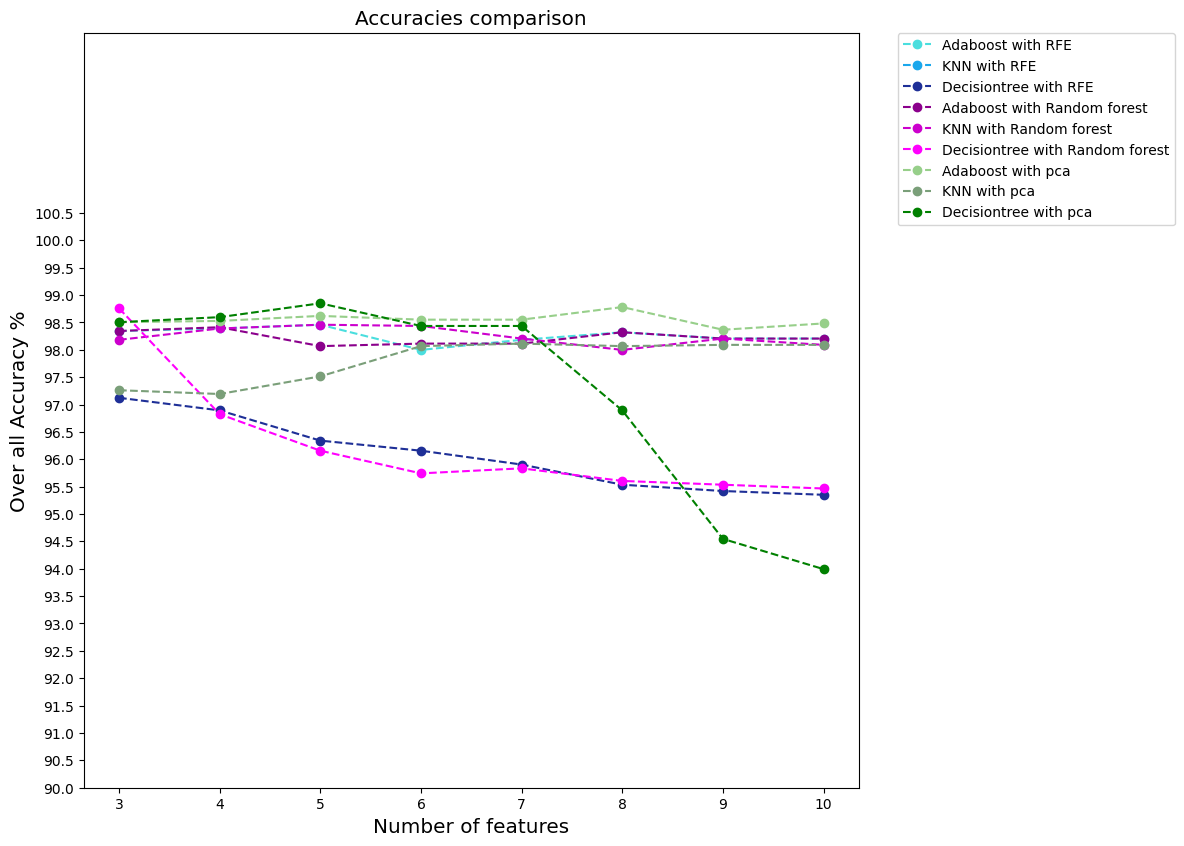

In [74]:
plot_against_Baseline2(np.arange(3,11,1), feature_selection_accuracy, "Accuracies comparison")

#### conclusion
Since that KNN is not support feature selection and I cannot obtain a result using them both, so I cannot complete the rest with using both of them together.
So, the comparison is really between both Random Forest and PCA. by looking to the graph plotted above, PCA gives a better overall accuracy.
So, I will complete the rest of the project using it.

#### number of features to use
All the are less than or morethan each other with very small number, so I tried hardly to choose the number of features which gives the best number for the three models ("AdaBoost", "KNN", "Decision tree"). I think that the best meet these conditions is 7, so the 7 features from PCA will be used.

## fit PCA with & features

Adaboost: 98.61910241657077


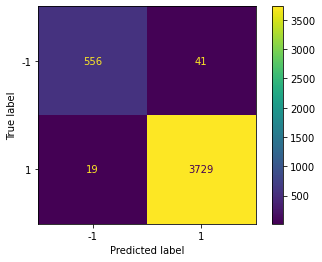

In [75]:
pca = PCA(n_components = 9)
pca_train = pca.fit_transform(xtrain)
pca_test = pca.transform(xtest)
ada_model_pca, ada_pred_pca, ada_accuracy_pca = model_Boosting(800, 1, pca_train, ytrain, pca_test, ytest)

K-NN: 98.06674338319908


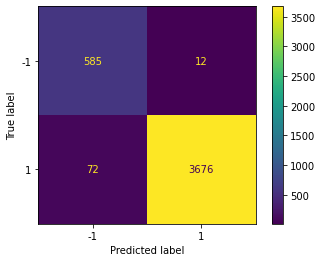

In [76]:
pca = PCA(n_components = 6)
pca_train = pca.fit_transform(xtrain)
pca_test = pca.transform(xtest)
knn_model_pca, knn_pred_pca, knn_accuracy_pca = model_knn(pca_train, ytrain, pca_test, ytest)

Decision Tree: 98.4349827387802


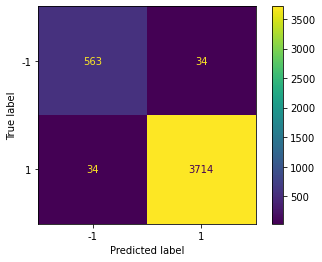

In [77]:
pca = PCA(n_components = 7)
pca_train = pca.fit_transform(xtrain)
pca_test = pca.transform(xtest)
dt_model_pca, dt_pred_pca, dt_accuracy_pca = model_decisiontree(pca_train, ytrain, pca_test, ytest)

In [78]:
accuracies = [ada_accuracy_pca, knn_accuracy_pca, dt_accuracy_pca]

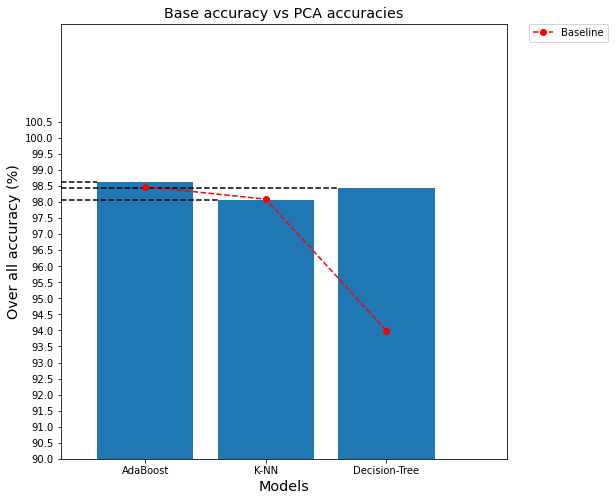

In [79]:
plt_bar(["AdaBoost", "K-NN", "Decision-Tree"], accuracies, [ada_accuracy, knn_accuracy, dt_accuracy], "Base accuracy vs PCA accuracies", 'Models', 'Over all accuracy (%)')

#### plot the data it self before and after applying PCA

In [80]:
from sklearn.manifold import TSNE
# Applying T-SNE to be able to visualize
reduced_train =  TSNE(n_components=2, random_state=0).fit_transform(xtrain)
reduced_test =  TSNE(n_components=2, random_state=0).fit_transform(ytrain)

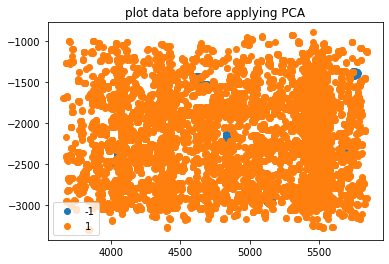

In [81]:
#plot data without applying PCA
def plotDataset(X, y, title):
    X, y = np.array(X), np.array(y)
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=label)
    plt.legend()
    plt.title(title)
    plt.show()
    
plotDataset(xtrain, ytrain.iloc[:, 0], "plot data before applying PCA")

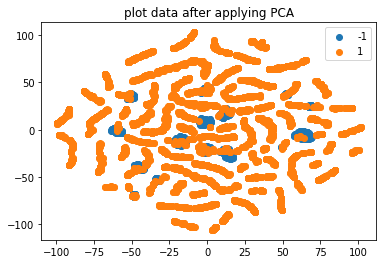

In [82]:
plotDataset(reduced_train, ytrain.iloc[:, 0], "plot data after applying PCA")

## Applying Stacking strategy

In [83]:
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier

#### Base estimators

In [84]:
#Define estimators
estimators = [DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
              AdaBoostClassifier(n_estimators = 400, learning_rate = 1, random_state=0),
              KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)]
estimators = {estimator.__class__.__name__: estimator for estimator in estimators}


In [85]:
print(f'Stacking Weighted accuracy Score (Aggregator LR)')
stacking = StackingClassifier([(estName, clone(est)) for estName, est in estimators.items()],
                              SVC(random_state = 0), n_jobs = -1)
stacking.fit(xtrain, ytrain)
predY = stacking.predict(xtest)
accuracy = accuracy_score(ytest, predY)*100
print(f'Stacking (Aggregator SVC): {accuracy}')

Stacking Weighted accuracy Score (Aggregator LR)
Stacking (Aggregator SVC): 98.66513233601842


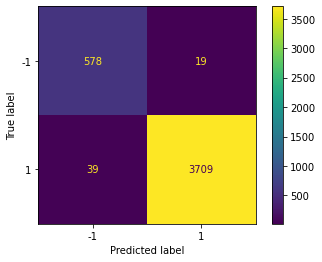

In [86]:
plot_confusion_matrix(stacking, xtest, ytest)

#### comment
It seems that the stacking classifier is not suitable at this situation. But I think that I have to dig deeper to understand the Stacking classifier to make that it is not preferrable to use stacking at such sitaution.

# Scaling features

In [87]:
# xtrain, ytrain, xtest, ytest

In [88]:
from sklearn.preprocessing import MinMaxScaler

In [89]:
scaler = MinMaxScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Multilayer perceptron
Using GridSearchCV to apply reach the best parameters with the best accuracy

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import tqdm

In [135]:
mlp_parameters = {'learning_rate_init': [0.00001, 0.001, 0.2, 0.9],
                 'power_t': [0.5, 0.2, 0.3],
                 'momentum': [0.1, 0.5, 0.7, 0.9],
                 'n_iter_no_change': [10, 5, 15]}

In [136]:
mpclassifier = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes=(15,15))
gscv = GridSearchCV(mpclassifier, mlp_parameters)
tqdm(gscv.fit(xtrain_scaled, ytrain))
print(gscv.best_params_)

0it [00:00, ?it/s]

{'learning_rate_init': 0.2, 'momentum': 0.9, 'n_iter_no_change': 5, 'power_t': 0.3}


#### applying the best parameters from the gridsearchCV
looping 10 times to overcome the centroid initialization problem and using the average accuracy as the model accuracy

In [ ]:
def model_mlpclassifier(x_train, x_test, y_train, y_test):
    mpclassifier = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes=(15,15),
                                learning_rate_init = 0.2, momentum = 0.9, n_iter_no_change = 5, power_t = 0.3)
    mpclassifier.fit(x_train, y_train)
    ypred = mpclassifier.predict(x_test)
    #print(accuracy_score(y_test, ypred))
    #plot_confusion_matrix(mpclassifier, x_test, y_test)
    
    return accuracy_score(y_test, ypred)*100, mpclassifier, ypred

In [ ]:
accuracy_sc = []
for i in range(0,10):
    accuracy, model, ypred =  model_mlpclassifier(xtrain_scaled, xtest_scaled, ytrain, ytest)
    accuracy_sc.append(accuracy)
    print(accuracy)
    plot_confusion_matrix(model, xtest_scaled, ytest)
    
    
mlp_accuracy_avg = sum(accuracy_sc)/len(accuracy_sc)
print(f'average accuracy: {mlp_accuracy}')

# SO now I will try to enhance the MLP model, I wil start by selecting the best number of features using SequentialFeatureSelector wrapper

In [105]:
from sklearn.feature_selection import SequentialFeatureSelector

In [128]:
def model_wrapper(model, x_train, x_test, y_train, n):
    sfs = SequentialFeatureSelector(model, n_features_to_select = n)
    sfs.fit(x_train, y_train)
    train = sfs.transform(x_train)
    test = sfs.transform(x_test)
    
    return train, test

In [132]:
mlp_selector_accuracy = []
mlp_model = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes=(15,15),
                      learning_rate = 'constant', momentum = 0.9, n_iter_no_change = 15, power_t = 0.5)
for i in range(3, 10):
    selector_train, selector_test = model_wrapper(mlp_model, xtrain, xtest, ytrain, i)
    mlp_accuracy, model, ypred = model_mlpclassifier(selector_train, selector_test, ytrain, ytest)
    mlp_selector_accuracy.append(mlp_accuracy)

KeyboardInterrupt: 

In [ ]:
plot_features_vs_accuracy(range(3, 10), mlp_selector_accuracy, [mlp_accuracy_avg]*len(mlp_pca_accuracy), 'MLP number of features Vs accuracies',
                          'Number of features', 'Accuracies')

#### 8 features gives the best accuracy of 87%

In [97]:
# pca = PCA(n_components = 8)
# pca_train = pca.fit_transform(xtrain)
# pca_test = pca.transform(xtest)

selector_train, selector_test = model_wrapper(model, xtrain, xtest, ytrain, n)

86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007
86.14499424626007


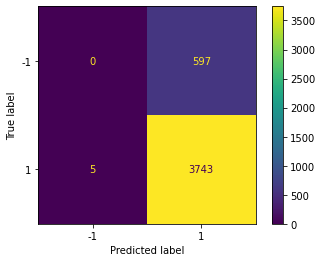

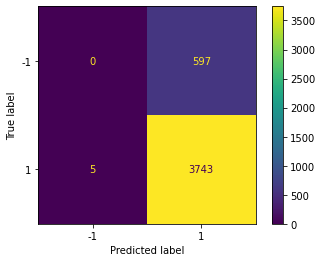

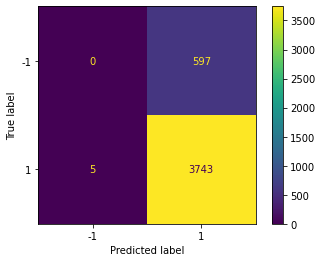

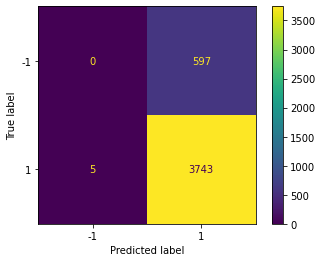

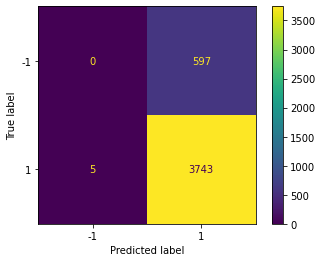

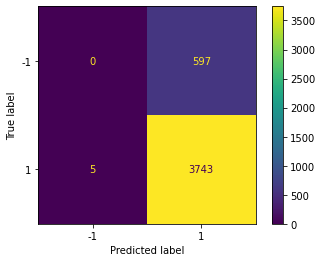

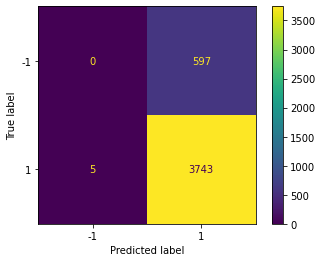

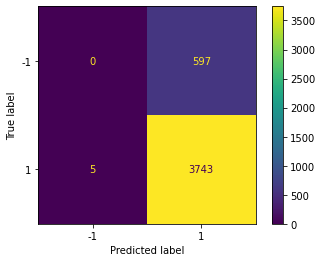

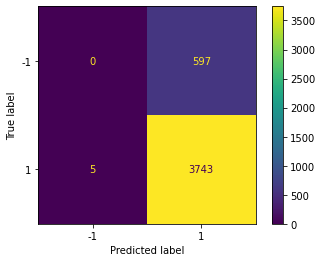

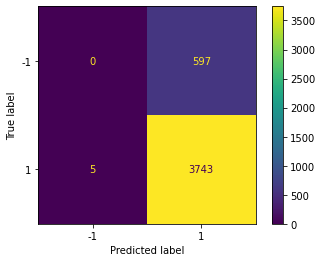

In [98]:
acc = []
for i in range(0,10):
    accuracy, model, y_pred = model_mlpclassifier(selector_train, selector_test, ytrain, ytest)
    print(accuracy)
    acc.append(acc)
    plot_confusion_matrix(model, pca_test, ytest)
    
average_acc = sum(acc)/len(acc)

# Clustering
the data, and use the predicted clusters as another feature during classification

In [99]:
from sklearn_som.som import SOM

In [100]:
k_accuracy = []
for i in range (2, 9):
    xtrain_cl, xtest_cl = xtrain.copy(), xtest.copy()
    som = SOM(m = i, n = i, dim = xtrain.shape[1], random_state = 0)
    ypred_train = som.fit_predict(xtrain.to_numpy())
    ypred_test = som.predict(xtest.to_numpy())
    xtrain_cl[str(i)] =  ypred_train
    xtest_cl[str(i)] =  ypred_test
    xtrain_scaled_cl = scaler.fit_transform(xtrain_cl)
    xtest_scaled_cl = scaler.transform(xtest_cl)
    acc = []
    for j in range(0,10):
        accuracy, model, y_pred = model_mlpclassifier(xtrain_scaled_cl, xtest_scaled_cl, ytrain, ytest)
        acc.append(accuracy)
    k_accuracy.append(sum(acc)/len(acc))
    

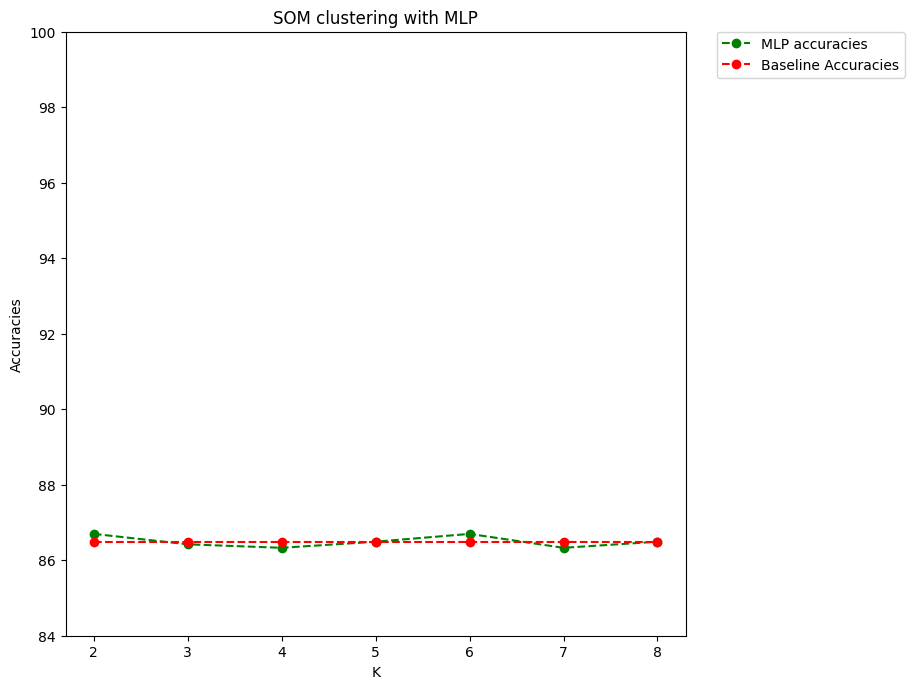

In [101]:
plot_features_vs_accuracy(range(2, 9), k_accuracy, [accuracy]*len(k_accuracy), 'SOM clustering with MLP',
                          'K', 'Accuracies')

getting the accuracy with the best M & N

In [102]:
xtrain_cl, xtest_cl = xtrain.copy(), xtest.copy()
som = SOM(m = 2, n = 2, dim = xtrain.shape[1], random_state = 0)
ypred_train = som.fit_predict(xtrain.to_numpy())
ypred_test = som.predict(xtest.to_numpy())
xtrain_cl[str(2)] =  ypred_train
xtest_cl[str(2)] =  ypred_test
xtrain_scaled_cl = scaler.fit_transform(xtrain_cl)
xtest_scaled_cl = scaler.transform(xtest_cl)
acc = []
for j in range(0,10):
    accuracy, model, y_pred = model_mlpclassifier(xtrain_scaled_cl, xtest_scaled_cl, ytrain, ytest)
    acc.append(accuracy)
accuracy_cl = sum(acc)/len(acc)

In [103]:
accuracy_cl

86.69735327963177

# hyper tune the parameters

In [104]:
# for i, j in zip(range(3, 10), range(10,30)):
#     mpclassifier = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes = (i, j), random_state = 0,
#                                 learning_rate = 'constant', momentum = 0.9, n_iter_no_change = 15, power_t = 0.5)
#     mpclassifier.fit(x_train, y_train)
#     ypred = mpclassifier.predict(x_test)

In [108]:
xtrain

,Latitude,Longitude,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,4421.4189,-3033.6925,4.0,13.0,40.0,40.0,9.0,91.0,0.0,131380.0
1,4421.5414,-3043.6606,4.0,23.0,40.0,30.0,9.0,91.0,0.0,131380.0
2,4421.0414,-3039.6326,4.0,33.0,40.0,20.0,9.0,91.0,0.0,121996.0
3,4418.6802,-3035.7741,4.0,43.0,40.0,10.0,9.0,91.0,0.0,121996.0
4,4477.2690,-1477.2228,15.0,49.0,30.0,30.0,5.0,47.0,0.0,140784.0
...,...,...,...,...,...,...,...,...,...,...
10134,5398.0715,-1363.8483,4.0,50.0,40.0,20.0,1.0,87.0,0.0,290929.0
10135,5404.4717,-1361.2367,5.0,0.0,40.0,10.0,1.0,87.0,0.0,300313.0
10136,5435.2708,-2177.0007,19.0,44.0,40.0,40.0,5.0,35.0,0.0,300303.0
10137,5435.5436,-2178.3546,19.0,54.0,40.0,30.0,5.0,35.0,0.0,300303.0
